In [12]:
## Import libraries in python
import argparse
import time
import json
import logging
import sys
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import tensorflow as tf
import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.metrics import mean_squared_error
from math import sqrt

from rp_creator import input_gen
from network import network_fit

In [13]:
def concat_vec(train_samples, test_samples):
    '''
    concatenate vectors for MLPs (this is not to be used for the case of CNN which allows 2D input)
    :param train_samples:
    :param test_samples:
    :return:
    '''
    # flatten 2D rp to 1D vector and concatenate all vectors.
    if len(train_samples.shape)==4:
        train_vec_samples = train_samples.reshape(train_samples.shape[0],
                                                  train_samples.shape[1]*train_samples.shape[2]*train_samples.shape[3])
        test_vec_samples = test_samples.reshape(test_samples.shape[0],
                                                  test_samples.shape[1]*test_samples.shape[2]*test_samples.shape[3])

    # concatenate all the flattened vectors. ( if 2D rps are already flattened)
    elif len(train_samples.shape)==3:
        train_vec_samples = train_samples.reshape(train_samples.shape[0],
                                                  train_samples.shape[1]*train_samples.shape[2])
        test_vec_samples = test_samples.reshape(test_samples.shape[0],
                                                  test_samples.shape[1]*test_samples.shape[2])


    return train_vec_samples, test_vec_samples


In [14]:
# Ignore tf err log
pd.options.mode.chained_assignment = None  # default='warn'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.get_logger().setLevel(logging.ERROR)

In [15]:
# random seed predictable
seed = 0
random.seed(seed)
np.random.seed(seed)

In [16]:
current_dir = '.'#os.path.dirname(os.path.abspath(__file__))

## Dataset path
train_FD001_path = current_dir +'/cmapss/train_FD001.csv'
test_FD001_path = current_dir +'/cmapss/test_FD001.csv'
RUL_FD001_path = current_dir+'/cmapss/RUL_FD001.txt'
FD001_path = [train_FD001_path, test_FD001_path, RUL_FD001_path]

train_FD002_path = current_dir +'/cmapss/train_FD002.csv'
test_FD002_path = current_dir +'/cmapss/test_FD002.csv'
RUL_FD002_path = current_dir +'/cmapss/RUL_FD002.txt'
FD002_path = [train_FD002_path, test_FD002_path, RUL_FD002_path]

train_FD003_path = current_dir +'/cmapss/train_FD003.csv'
test_FD003_path = current_dir +'/cmapss/test_FD003.csv'
RUL_FD003_path = current_dir +'/cmapss/RUL_FD003.txt'
FD003_path = [train_FD003_path, test_FD003_path, RUL_FD003_path]

train_FD004_path =current_dir +'/cmapss/train_FD004.csv'
test_FD004_path = current_dir +'/cmapss/test_FD004.csv'
RUL_FD004_path = current_dir +'/cmapss/RUL_FD004.txt'
FD004_path = [train_FD004_path, test_FD004_path, RUL_FD004_path]

In [17]:
## Assign columns name
cols = ['unit_nr', 'cycles', 'os_1', 'os_2', 'os_3']
cols += ['sensor_{0:02d}'.format(s + 1) for s in range(26)]
col_rul = ['RUL_truth']

## Read csv file to pandas dataframe
FD_path = ["none", FD001_path, FD002_path, FD003_path, FD004_path]
dp_str = ["none", "FD001", "FD002", "FD003", "FD004"]

## temporary model path for NN
model_path = current_dir +'/temp_net.h5'

In [18]:
dp = FD_path[1]
subdataset = dp_str[1]
sequence_length = 10
thres_type = None
thres_value = 50
device = 'cpu'
method = 'rps'
n_hidden1 = 100
n_hidden2 = 10
epochs = 1000
batch = 700
verbose = 2
flatten = True
visualize = True

In [19]:
# Sensors not to be considered (those that do not disclose any pattern in their ts)
sensor_drop = ['sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

start = time.time()

print("Dataset: ", subdataset)
print("Seq_len: ", sequence_length)


Dataset:  FD001
Seq_len:  10


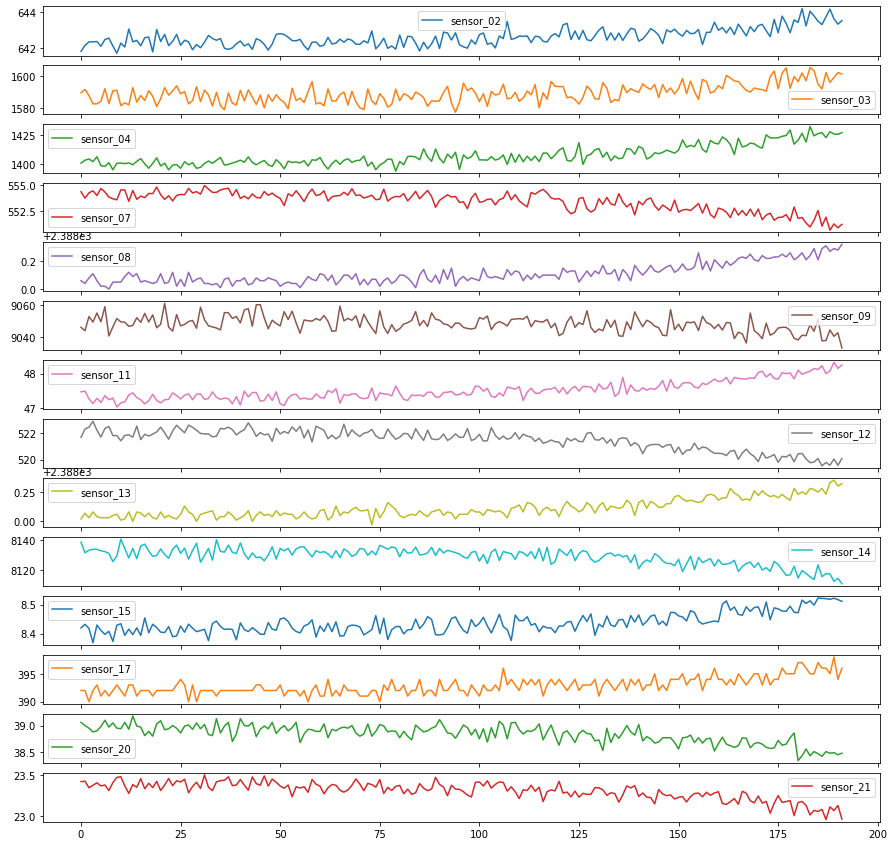

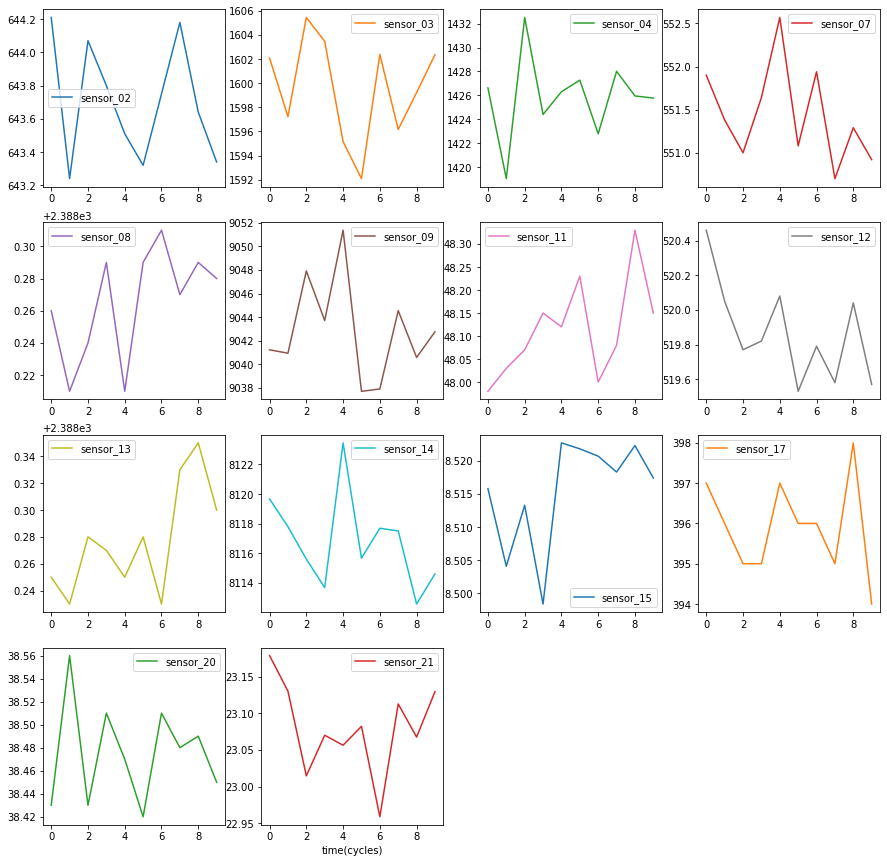

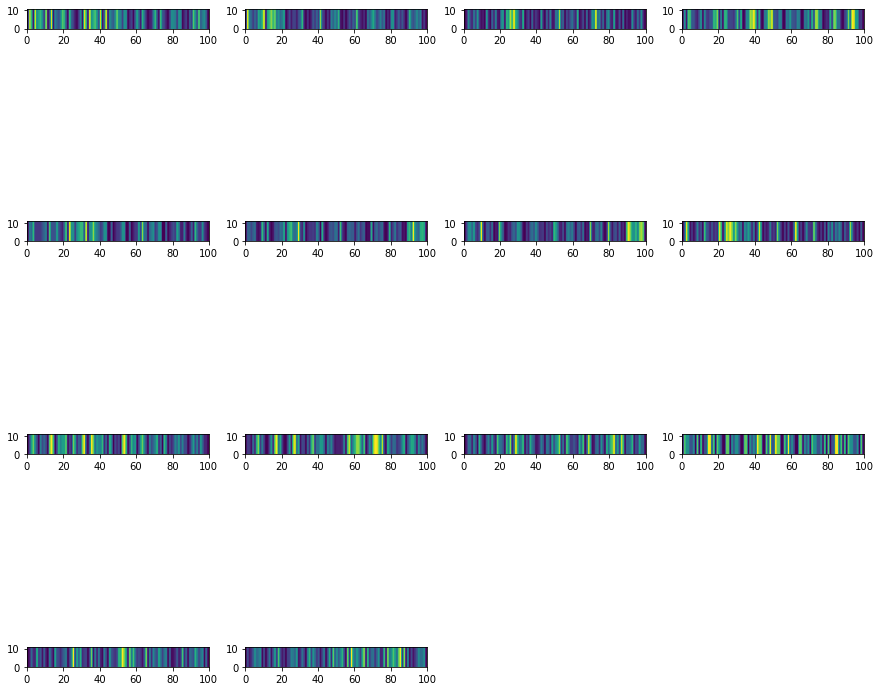

In [20]:
data_class = input_gen(data_path_list=dp, sequence_length=sequence_length, sensor_drop= sensor_drop, visualize=visualize)

if method == 'rps':
    train_samples, label_array_train, test_samples, label_array_test = data_class.rps(
        thres_type=thres_type,
        thres_percentage=thres_value,
        flatten=flatten,
        visualize=visualize)

elif method == 'jrp': # please implement any method if needed
    pass

In [21]:
print ("train_samples.shape: ", train_samples.shape) # shape = (samples, sensors, height, width)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, sensors, height, width)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)

train_samples, test_samples = concat_vec(train_samples, test_samples)

print ("train_samples.shape: ", train_samples.shape) # shape = (samples, sensors, height, width)
print ("label_array_train.shape: ", label_array_train.shape) # shape = (samples, label)
print ("test_samples.shape: ", test_samples.shape) # shape = (samples, sensors, height, width)
print ("label_array_test.shape: ", label_array_test.shape) # shape = (samples, ground truth)


train_samples.shape:  (19631, 14, 100)
label_array_train.shape:  (19631, 1)
test_samples.shape:  (100, 14, 100)
label_array_test.shape:  (100, 1)
train_samples.shape:  (19631, 1400)
label_array_train.shape:  (19631, 1)
test_samples.shape:  (100, 1400)
label_array_test.shape:  (100, 1)


Initializing network...
Epoch 1/1000
23/23 - 0s - loss: 3577.0356 - root_mean_squared_error: 59.8083 - mae: 50.6464 - val_loss: 2158.7517 - val_root_mean_squared_error: 46.4624 - val_mae: 41.4220

Epoch 00001: val_root_mean_squared_error improved from inf to 46.46237, saving model to ./temp_net.h5
Epoch 2/1000
23/23 - 0s - loss: 2026.3523 - root_mean_squared_error: 45.0150 - mae: 39.4863 - val_loss: 2018.6814 - val_root_mean_squared_error: 44.9297 - val_mae: 39.8692

Epoch 00002: val_root_mean_squared_error improved from 46.46237 to 44.92974, saving model to ./temp_net.h5
Epoch 3/1000
23/23 - 0s - loss: 1900.2064 - root_mean_squared_error: 43.5914 - mae: 38.3788 - val_loss: 1931.7656 - val_root_mean_squared_error: 43.9519 - val_mae: 38.8495

Epoch 00003: val_root_mean_squared_error improved from 44.92974 to 43.95186, saving model to ./temp_net.h5
Epoch 4/1000
23/23 - 0s - loss: 1798.8439 - root_mean_squared_error: 42.4128 - mae: 37.3200 - val_loss: 1865.3707 - val_root_mean_squared_err

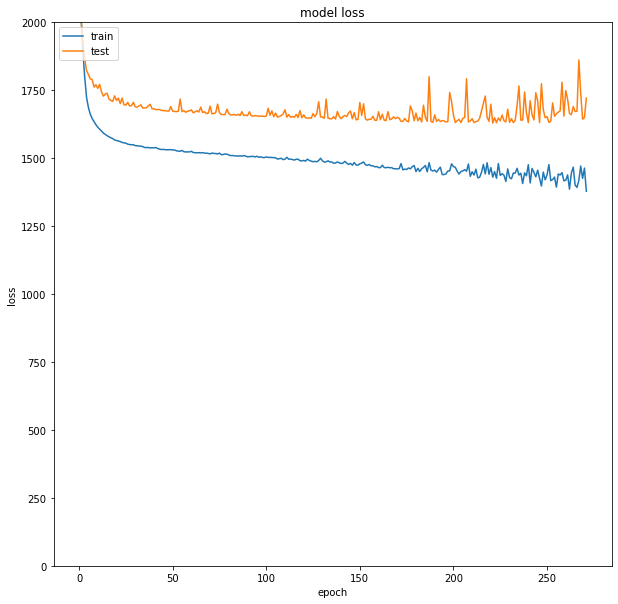

        y_pred  y_truth       diff  diff(ratio)     diff(%)       rmse
0    90.681007    112.0  21.318993     0.190348   19.034815  37.541861
1    79.767891     98.0  18.232109     0.186042   18.604193  37.541861
2    86.047478     69.0  17.047478     0.247065   24.706490  37.541861
3    97.368141     82.0  15.368141     0.187416   18.741636  37.541861
4    71.537254     91.0  19.462746     0.213876   21.387632  37.541861
5    66.880173     93.0  26.119827     0.280858   28.085836  37.541861
6    79.599297     91.0  11.400703     0.125282   12.528245  37.541861
7    75.592133     95.0  19.407867     0.204293   20.429335  37.541861
8    92.911720    111.0  18.088280     0.162957   16.295748  37.541861
9    66.932831     96.0  29.067169     0.302783   30.278301  37.541861
10   77.737289     97.0  19.262711     0.198585   19.858465  37.541861
11   62.712242    124.0  61.287758     0.494256   49.425610  37.541861
12   57.219383     95.0  37.780617     0.397691   39.769070  37.541861
13   9

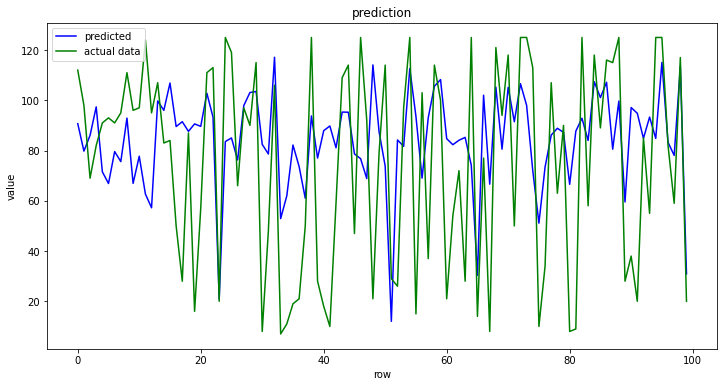

FD001 test RMSE:  37.5418614006002
FD001 test Score:  30627.07964767061
Computing time:  51.85090088844299


In [22]:
mlps_net = network_fit(train_samples, label_array_train, test_samples, label_array_test,
                       model_path = model_path, n_hidden1=n_hidden1, n_hidden2=n_hidden2, verbose=verbose)

trained_net = mlps_net.train_net(epochs=epochs, batch_size=batch)
rms, score = mlps_net.test_net(trained_net)


print(subdataset + " test RMSE: ", rms)
print(subdataset + " test Score: ", score)

end = time.time()
print("Computing time: ", end - start)